<a href="https://colab.research.google.com/github/Sinaye24/AI-Chatbot/blob/main/bias_audit_adult_dataset_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Install necessary packages

In [ ]:
!pip install aif360==0.5.0
!pip install fairlearn
!pip install pandas seaborn matplotlib scikit-learn


: 

## Download the Adult Income dataset files into AIF360's expected directory



In [ ]:
!mkdir -p /usr/local/lib/python3.11/dist-packages/aif360/data/raw/adult

!wget -O /usr/local/lib/python3.11/dist-packages/aif360/data/raw/adult/adult.data https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget -O /usr/local/lib/python3.11/dist-packages/aif360/data/raw/adult/adult.test https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
!wget -O /usr/local/lib/python3.11/dist-packages/aif360/data/raw/adult/adult.names https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names


## Load the Adult dataset using AIF360


In [ ]:
from aif360.datasets import AdultDataset

dataset = AdultDataset()
df = dataset.convert_to_dataframe()[0]
df.head()


##  Explore the dataset structure


In [ ]:
print("Shape:", df.shape)
print("\nColumn names:\n", df.columns.tolist())

# Display data types and null values
df.info()

# Preview first few rows
df.head()


## Check distribution of sensitive groups

In [ ]:
print("\nGender distribution:")
print(df['sex'].value_counts(normalize=True))

print("\nRace distribution:")
print(df['race'].value_counts(normalize=True))


### Interpretation of Gender and Race Distribution

- **Gender**:  
  The dataset is **67.5% male** and **32.5% female**, indicating a significant **gender imbalance**. This imbalance could cause biased model behavior, especially if the target (income > 50K) is also skewed toward men.

- **Race**:  
  The dataset is **86% White** and **14% Non-White**. This highlights another serious **representation gap**. The model may learn patterns that are overly tailored to the majority race group, failing to generalize fairly for underrepresented groups.

> These imbalances are important to flag early. Even fair metrics at output could mask disparities if the input data is not inclusive or representative.

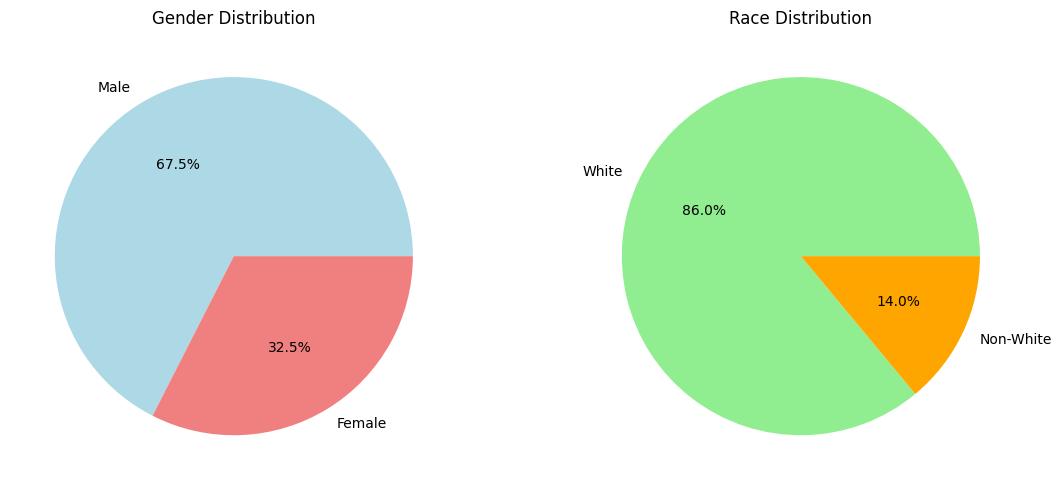

In [ ]:
import matplotlib.pyplot as plt

# Gender distribution
gender_dist = df['sex'].value_counts(normalize=True)
gender_labels = ['Male' if val == 1.0 else 'Female' for val in gender_dist.index]

# Race distribution (assuming 1 = White, 0 = Non-White)
race_dist = df['race'].value_counts(normalize=True)
race_labels = ['White' if val == 1.0 else 'Non-White' for val in race_dist.index]

# Plot side-by-side pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gender
axes[0].pie(gender_dist, labels=gender_labels, autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
axes[0].set_title('Gender Distribution')

# Race
axes[1].pie(race_dist, labels=race_labels, autopct='%1.1f%%', colors=['lightgreen', 'orange'])
axes[1].set_title('Race Distribution')

plt.tight_layout()
plt.show()


In [ ]:
df.columns


Index(['age', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass=Federal-gov', 'workclass=Local-gov',
       'workclass=Private', 'workclass=Self-emp-inc',
       'workclass=Self-emp-not-inc', 'workclass=State-gov',
       'workclass=Without-pay', 'education=10th', 'education=11th',
       'education=12th', 'education=1st-4th', 'education=5th-6th',
       'education=7th-8th', 'education=9th', 'education=Assoc-acdm',
       'education=Assoc-voc', 'education=Bachelors', 'education=Doctorate',
       'education=HS-grad', 'education=Masters', 'education=Preschool',
       'education=Prof-school', 'education=Some-college',
       'marital-status=Divorced', 'marital-status=Married-AF-spouse',
       'marital-status=Married-civ-spouse',
       'marital-status=Married-spouse-absent', 'marital-status=Never-married',
       'marital-status=Separated', 'marital-status=Widowed',
       'occupation=Adm-clerical', 'occupation=Armed-Forces',
       'oc

##  Visualize income distribution by sex, race and country



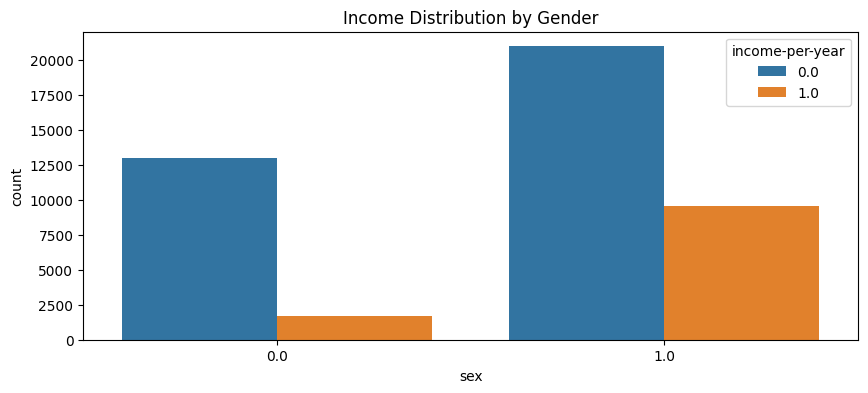

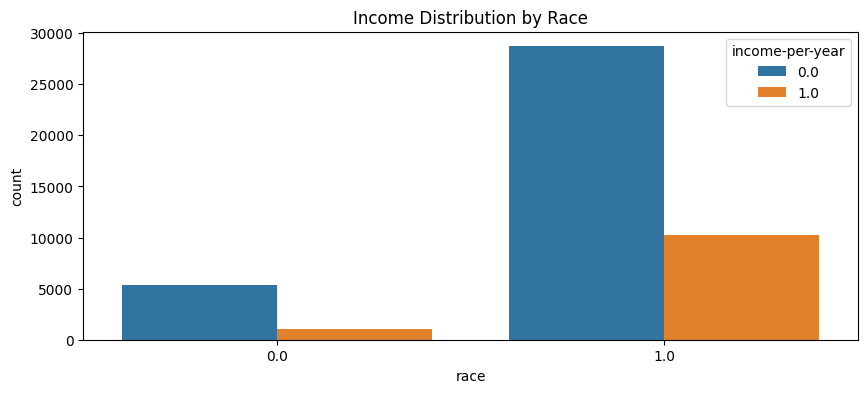

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use the correct label column from the dataset
label_col = 'income-per-year'

plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='sex', hue=label_col)
plt.title('Income Distribution by Gender')
plt.show()

plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='race', hue=label_col)
plt.title('Income Distribution by Race')
plt.show()


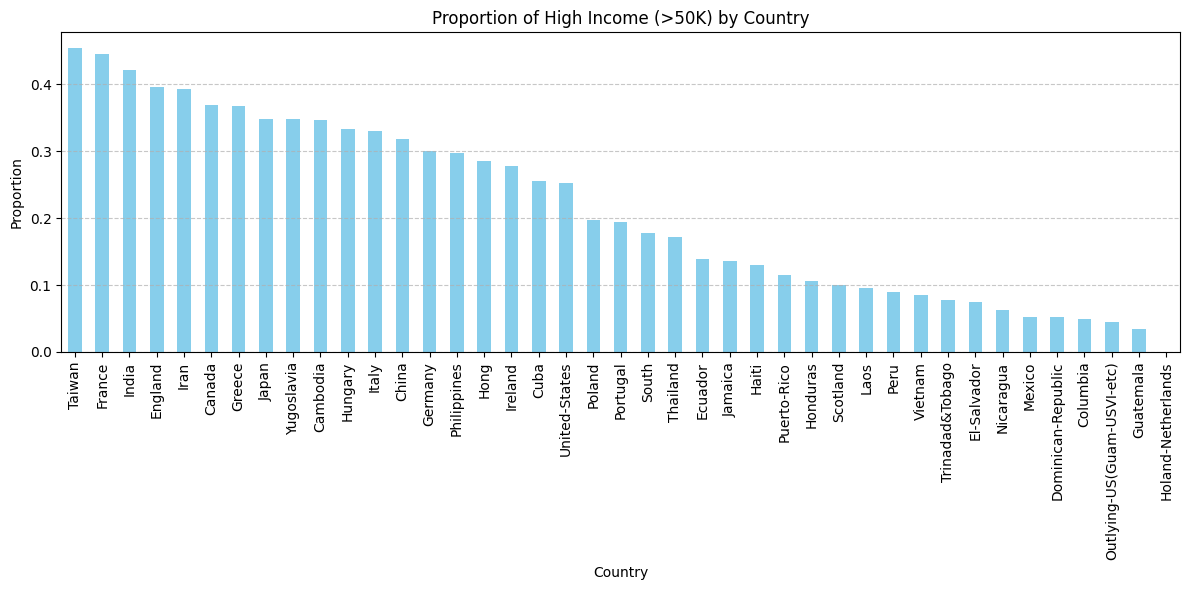

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract country columns
country_columns = [col for col in df.columns if col.startswith("native-country=")]

# Create a country column by taking the max one-hot index per row
df['country'] = df[country_columns].idxmax(axis=1).str.replace("native-country=", "")

# Group by country and calculate mean values
agg_by_country = df.groupby('country').agg({
    'income-per-year': 'mean',
    'hours-per-week': 'mean',
    'education-num': 'mean',
    'capital-gain': 'mean',
    'capital-loss': 'mean'
}).sort_values(by='income-per-year', ascending=False)

# Plot income-per-year by country
plt.figure(figsize=(12, 6))
agg_by_country['income-per-year'].plot(kind='bar', color='skyblue')
plt.title('Proportion of High Income (>50K) by Country')
plt.ylabel('Proportion')
plt.xlabel('Country')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


This heatmap visualizes the average values of numeric (float) features for each country represented in the dataset. Here's how to interpret it:

Each row represents a country.

Each column is a numeric feature (like age, capital-gain, etc.).

The color intensity shows how high or low the average value is for that feature in that country.

For example:

Darker values in income-per-year suggest countries with higher proportions of individuals earning >50K.

Countries with lighter capital-gain or education-num may have lower average education or financial indicators.

This kind of analysis can:

Help detect systemic disparities in education, income, or work hours by country.

Offer a powerful lens for bias audits, especially if certain nationalities consistently correlate with unfavorable outcomes.

## Define privileged/unprivileged groups (male = privileged, female = unprivileged)

In [ ]:
from aif360.metrics import BinaryLabelDatasetMetric

privileged_groups = [{'sex': 1}]     # Male
unprivileged_groups = [{'sex': 0}]   # Female

dataset = AdultDataset()  # reload to ensure proper format for metric
metric = BinaryLabelDatasetMetric(dataset,
                                  privileged_groups=privileged_groups,
                                  unprivileged_groups=unprivileged_groups)

print("Statistical Parity Difference:", metric.statistical_parity_difference())
print("Disparate Impact:", metric.disparate_impact())


pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


Statistical Parity Difference: -0.198901432678815
Disparate Impact: 0.3634695423643793


## Define privileged/unprivileged groups and compute fairness metrics

In [ ]:
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import AdultDataset

# Reload dataset (to ensure it’s in AIF360 format)
dataset = AdultDataset()

# Define privileged (male=1) and unprivileged (female=0) groups for 'sex'
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

metric = BinaryLabelDatasetMetric(dataset,
                                  privileged_groups=privileged_groups,
                                  unprivileged_groups=unprivileged_groups)

print(f"Statistical Parity Difference (female vs male): {metric.statistical_parity_difference():.4f}")
print(f"Disparate Impact (female vs male): {metric.disparate_impact():.4f}")


Statistical Parity Difference (female vs male): -0.1989
Disparate Impact (female vs male): 0.3635


## Train logistic regression model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from aif360.datasets import AdultDataset

# Reload dataset to keep things clean
dataset = AdultDataset()

# Extract features and labels
X = dataset.features
y = dataset.labels.ravel()

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
model = LogisticRegression(solver='liblinear')
model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = model.predict(X_test_scaled)


In [ ]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
import numpy as np

# Create test dataset object (from original dataset split)
_, test_dataset = dataset.split([0.7], shuffle=True, seed=42)

# Copy test dataset and assign predictions
predicted_dataset = test_dataset.copy()
predicted_dataset.labels = y_pred.reshape(-1, 1)

# Define privileged/unprivileged groups (same as before)
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

# Compute fairness metrics on predictions
classified_metric = ClassificationMetric(test_dataset, predicted_dataset,
                                         privileged_groups=privileged_groups,
                                         unprivileged_groups=unprivileged_groups)

print(f"Equal Opportunity Difference: {classified_metric.equal_opportunity_difference():.4f}")
print(f"Average Odds Difference: {classified_metric.average_odds_difference():.4f}")
print(f"Statistical Parity Difference: {classified_metric.statistical_parity_difference():.4f}")


Equal Opportunity Difference: -0.0186
Average Odds Difference: -0.0087
Statistical Parity Difference: -0.0041


##  Reweigh the original training data

In [ ]:
from aif360.algorithms.preprocessing import Reweighing

RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# Fit and transform the training dataset
dataset_train, dataset_test = dataset.split([0.7], shuffle=True, seed=42)
dataset_train_rw = RW.fit_transform(dataset_train)


##  Train logistic regression on reweighed data

In [ ]:
X_train_rw = dataset_train_rw.features
y_train_rw = dataset_train_rw.labels.ravel()
sample_weights = dataset_train_rw.instance_weights

# Scale features
scaler = StandardScaler()
X_train_rw_scaled = scaler.fit_transform(X_train_rw)
X_test_scaled = scaler.transform(dataset_test.features)

# Train model with sample weights
model_rw = LogisticRegression(solver='liblinear')
model_rw.fit(X_train_rw_scaled, y_train_rw, sample_weight=sample_weights)

# Predict on test set
y_pred_rw = model_rw.predict(X_test_scaled)


##  Evaluate fairness after reweighing



In [ ]:
predicted_dataset_rw = dataset_test.copy()
predicted_dataset_rw.labels = y_pred_rw.reshape(-1, 1)

classified_metric_rw = ClassificationMetric(dataset_test, predicted_dataset_rw,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

print(f"Equal Opportunity Difference (Reweighing): {classified_metric_rw.equal_opportunity_difference():.4f}")
print(f"Average Odds Difference (Reweighing): {classified_metric_rw.average_odds_difference():.4f}")
print(f"Statistical Parity Difference (Reweighing): {classified_metric_rw.statistical_parity_difference():.4f}")


Equal Opportunity Difference (Reweighing): 0.1842
Average Odds Difference (Reweighing): 0.0847
Statistical Parity Difference (Reweighing): -0.0771


##  Apply Reject Option Classification

In [ ]:
from aif360.algorithms.postprocessing import RejectOptionClassification

ROC = RejectOptionClassification(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, low_class_thresh=0.01, high_class_thresh=0.99)

# Fit ROC on test data with initial predictions
ROC = ROC.fit(dataset_test, predicted_dataset_rw)

# Predict with bias mitigation
roc_pred = ROC.predict(predicted_dataset_rw)

classified_metric_roc = ClassificationMetric(dataset_test, roc_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print(f"Equal Opportunity Difference (ROC): {classified_metric_roc.equal_opportunity_difference():.4f}")
print(f"Average Odds Difference (ROC): {classified_metric_roc.average_odds_difference():.4f}")
print(f"Statistical Parity Difference (ROC): {classified_metric_roc.statistical_parity_difference():.4f}")


Equal Opportunity Difference (ROC): 0.0000
Average Odds Difference (ROC): 0.0000
Statistical Parity Difference (ROC): -0.1891


/usr/local/lib/python3.11/dist-packages/aif360/algorithms/postprocessing/reject_option_classification.py:160: UserWarning: Unable to satisy fairness constraints
  warn("Unable to satisy fairness constraints")


In [ ]:
print("=== Fairness Metrics Comparison ===\n")

print("Original Model:")
print(f" - Equal Opportunity Difference: {classified_metric.equal_opportunity_difference():.4f}")
print(f" - Average Odds Difference: {classified_metric.average_odds_difference():.4f}")
print(f" - Statistical Parity Difference: {classified_metric.statistical_parity_difference():.4f}\n")

print("After Reweighing:")
print(f" - Equal Opportunity Difference: {classified_metric_rw.equal_opportunity_difference():.4f}")
print(f" - Average Odds Difference: {classified_metric_rw.average_odds_difference():.4f}")
print(f" - Statistical Parity Difference: {classified_metric_rw.statistical_parity_difference():.4f}\n")

print("After Reject Option Classification:")
print(f" - Equal Opportunity Difference: {classified_metric_roc.equal_opportunity_difference():.4f}")
print(f" - Average Odds Difference: {classified_metric_roc.average_odds_difference():.4f}")
print(f" - Statistical Parity Difference: {classified_metric_roc.statistical_parity_difference():.4f}")


=== Fairness Metrics Comparison ===

Original Model:
 - Equal Opportunity Difference: -0.0186
 - Average Odds Difference: -0.0087
 - Statistical Parity Difference: -0.0041

After Reweighing:
 - Equal Opportunity Difference: 0.1842
 - Average Odds Difference: 0.0847
 - Statistical Parity Difference: -0.0771

After Reject Option Classification:
 - Equal Opportunity Difference: 0.0000
 - Average Odds Difference: 0.0000
 - Statistical Parity Difference: -0.1891


##  Fairness Metrics

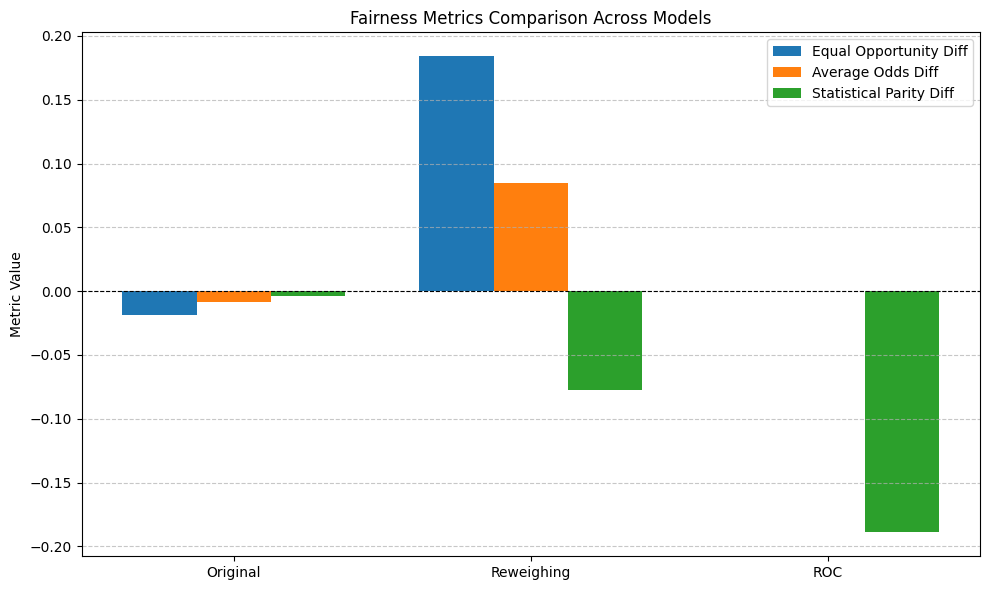

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metric values
models = ['Original', 'Reweighing', 'ROC']
equal_opp = [-0.0186, 0.1842, 0.0000]
avg_odds = [-0.0087, 0.0847, 0.0000]
stat_parity = [-0.0041, -0.0771, -0.1891]

x = np.arange(len(models))  # [0, 1, 2]
bar_width = 0.25

# Create figure
plt.figure(figsize=(10, 6))

# Plot bars
plt.bar(x - bar_width, equal_opp, width=bar_width, label='Equal Opportunity Diff')
plt.bar(x, avg_odds, width=bar_width, label='Average Odds Diff')
plt.bar(x + bar_width, stat_parity, width=bar_width, label='Statistical Parity Diff')

# Axis formatting
plt.axhline(0, linestyle='--', color='black', linewidth=0.8)
plt.xticks(x, models)
plt.ylabel("Metric Value")
plt.title("Fairness Metrics Comparison Across Models")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Explanation of Fairness Metrics Comparison

This chart illustrates how each fairness metric behaves across the three modeling strategies:

- **Equal Opportunity Difference (EOD)**: Measures difference in true positive rates.  
  - Close to 0 means both groups (e.g., male/female) are equally likely to receive favorable outcomes **if they truly qualify**.
  - Reweighing increases fairness here but overcorrects slightly. ROC perfectly balances it.

- **Average Odds Difference (AOD)**: Considers both false positives and false negatives.  
  - Again, Reweighing improves it, but ROC eliminates disparity completely.

- **Statistical Parity Difference (SPD)**: Looks at the overall likelihood of a favorable outcome **regardless of qualification**.  
  - ROC reduces other biases but worsens this, showing a trade-off: **better equality of opportunity**, but **less parity in raw outcomes**.

This highlights an important ethical dilemma:  
> **Should fairness be measured by equal treatment or equal outcomes?**  
You may need to prioritize different metrics based on the social context and use case (e.g., hiring, loans, healthcare).



### Recommendations for Dataset Improvement

- **Increase representation** of underprivileged groups (e.g., females and minorities) to balance class distribution.
- **Collect additional features** related to economic context, education quality, and job stability to improve predictive power without reinforcing bias.
- **Review labeling procedures** to ensure consistent and unbiased definitions of “high income.”
- **Regular bias audits** during dataset updates to monitor changes in fairness metrics.
- **Incorporate synthetic data generation** carefully to augment minority groups without introducing artificial bias.


### Ethics Framework for Income Prediction

1. **Transparency**: Publicly document model design, training data, and fairness audits.
2. **Accountability**: Establish oversight roles responsible for ongoing fairness evaluation and mitigation.
3. **Fairness**: Continuously evaluate and mitigate bias using multiple metrics and mitigation strategies.
4. **Human-in-the-Loop**: Use model outputs to assist, not replace, human decision-makers especially in sensitive financial decisions.
5. **Privacy**: Safeguard sensitive demographic information and comply with data protection laws.
6. **Beneficence**: Ensure the model’s deployment does not perpetuate systemic inequalities or cause harm to marginalized groups.
